# infos

In [ ]:
# Version 1.2

# Notebook d'étude d'un modèle entrainé

### Changelogs :


v1.2 :
- Ajout du chargement de la variable history avec la librairie pickle
- Ajout de l'étude des courbes d'accuracy et de val_accuracy durant l'entrainement du modèle


v1.1 :
- Nettoyage du code pour livraison projet
- Ajout rapport de classification
- Ajout matrice de confusion


v1.0 :
- Chargement du modèle et tests sur images

# Definition des URL

In [237]:
# Vérifier que les chemins soient correct avant toutes opérations
chemin_images = '../../images/'
chemin_csv = '../data/top10.csv'

# Dimensions des images
img_dim = (200,200)
img_shape = (200,200,3)

Pour le choix des dim images selon modèle :

(224,224)
gpot_v01_echantillon 
gpot_v01_full
gpot_v01_full_tri
gpot_v02_ech_tri

(200,200)
gpot_v02_full_tri_undersampled
gpot_v02b_full_tri_undersampled

# Librairies à charger

In [238]:
# Librairies servant à charger le modèle
from tensorflow import keras

# Librairies servant à charger les données
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf

# Librairies servant à charger les images et les afficher
import requests
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt


# Librairies utilisées pour l'évaluation du modèle une fois entrainé
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Librairies utilisées pour des sauvegardes et chargements de variables
import pickle

# Fonctions

In [239]:
def import_df(chemin_images, chemin_csv, pourcentage_echantillon=0.1):
    '''Importe le fichier csv et construit 2 df :
        - Le DF basé sur le CSV original
        - Un DF echantillon comportant 10% de données aléatoires du DF original
    '''
    
    
    # import du df
    df = pd.read_csv(chemin_csv, low_memory=False)
    print(f"Nombre d'images chargées pour df: {df.shape[0]}")
    print(f"Nb especes dans df: {df['label'].nunique()}")


    # Contruction de l'echantillon
    L = len(df)
    L_ech = int(pourcentage_echantillon * L)
    df_ech = df.sample(n=L_ech, random_state=10)
    df_ech.reset_index(inplace=True, drop=True)
    print(f"Nombre d'images chargées pour df_ech: {df_ech.shape[0]}")
    print(f"Nb especes dans df_ech: {df_ech['label'].nunique()}")

    return df, df_ech

In [240]:
def augment_img(image_path, label):

   '''
    Modifie les images aléatoirement dans le dataset qui sera soumis au modèle.
      - image_path : URL des images (contenue dans la variable 'image_url' dans le DF chargé),
      - label : Variable contenant les classes
   '''

   # Lecture image, decodage
   img = tf.io.read_file(image_path)
   img = tf.image.decode_png(img, channels=3)

   # Redimensionnement selon dimensions définies en début de notebook (img_dim)
   img = tf.image.resize(img, img_dim)

   # Pre-processing pour transfert learning, modèle efficienNet
   img = preprocess_input(img)

   # Conversion du type en float32
   img = tf.image.convert_image_dtype(img, tf.float32)

   # Normalisation
   img = (img - tf.math.reduce_min(img)) / (tf.math.reduce_max(img) - tf.math.reduce_min(img))

   return img, label

In [241]:
def create_tf_dataset(image_path, labels, batch_size):
    '''
    Créé un dataset Tensorflow selon les paramètres précisés.
        - image_path : chemin relatif de la variable contenant les images
        - labels : variable contenant les labels
        - batch_size : taille des batchs
    '''

    image_path = image_path.tolist()  # Convertir les chemins d'images en liste
    labels = labels.tolist()          # Convertir les labels en liste



    # Construction du Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    # .map appelle la fonction d'augmentation d'image définie
    dataset = dataset.map(augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Mélange aléatoire du dataset
    dataset = dataset.shuffle(buffer_size=len(image_path))

    # Découpage en batch
    dataset = dataset.batch(batch_size)

    # Optimisation : Charge les données en arrière-plan et maintien la charge CPU/GPU
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Chargement du DF

In [242]:
df, df_ech = import_df(chemin_images, chemin_csv)

Nombre d'images chargées pour df: 60481
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6048
Nb especes dans df_ech: 10


In [243]:
nom_classes = {
    0: "Agaricales",
    1: "Agaricus",
    2: "Amanita",
    3: "Cortinarius",
    4: "Entoloma",
    5: "Inocybe",
    6: "Mycena",
    7: "Polyporales",
    8: "Psathyrella",
    9: "Russula"}

# Pipeline TensorFlow

In [244]:
data = df.drop('label', axis=1)
target = df['label']

s = LabelEncoder()
target = s.fit_transform(target) # Encodage de la variable 'label'

# On construit le jeu d'entrainement. X_temp et y_temps servent pour la construction des jeux de test et validation
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.25, random_state=10)

# On split les temp en 50% pour test, 50% pour validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

In [245]:
batch_size = 64
# Les datasets sont créés à partir de la fonction create_tf_dataset définie dans la partie 'Fonctions'
ds_test = create_tf_dataset(X_test.image_url, y_test, batch_size)

# Chargement du modèle

In [263]:
#nom_model = '../model/gpot_v01_full'
#nom_model = '../model/gpot_v01_full_tri'
#nom_model = '../model/gpot_v02_ech_tri'
#nom_model = '../model/gpot_v02_full_tri_undersampled'
nom_model = '../model/gpot_v02b_full_tri_undersampled'
model = keras.models.load_model(nom_model)

In [264]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 7329730 (27.96 MB)
Trainable params: 129418 (505.54 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


# Evaluation du modèle

In [ ]:
# Chargement de l'historique d'entrainement du modèle :

# Spécifiez le chemin d'accès complet au fichier enregistré
chemin_acces = '../history/history_gpot_v02b_full_tri_undersampled.pkl'

# Charger la variable depuis le fichier
with open(chemin_acces, 'rb') as file:
    history_gpot_v02b_full_tri_undersampled = pickle.load(file)

history = history_gpot_v02b_full_tri_undersampled

##### Accuracy sur test

In [266]:
test_loss, test_accuracy = model.evaluate(ds_test)
print("Test accuracy:", test_accuracy)

119/119 [==============================] - 291s 2s/step - loss: 1.5989 - accuracy: 0.4831
Test accuracy: 0.4831371605396271


##### Courbes accuracy & val_accuracy

In [ ]:
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0,1])
plt.legend()
plt.show()

# Prediction image dataset

In [270]:
# Chargement aléatoire d'une image
random_image_row = df.sample(n=1)  # Selection d'une ligne au hasard dans le df
img_path = random_image_row['image_url'].values[0]  # Génère le chemin correspondant à l'image aléaotire

img = image.load_img(img_path, target_size=img_dim)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [271]:
# Faites une prédiction avec le modèle sur l'image chargée
predictions = model.predict(x)
index_classe_predite = np.argmax(predictions)
nom_classe_predite = nom_classes[index_classe_predite]

1/1 [==============================] - 1s 920ms/step


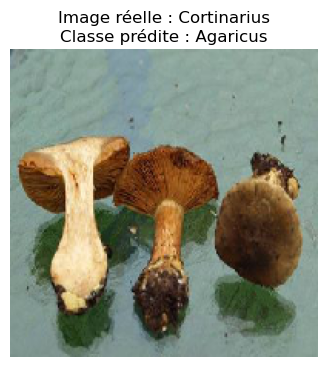

In [272]:
# Obtenir la classe réelle par rapport au chemin de l'image
image_label = df.loc[df['image_url'] == img_path]['label'].values[0]

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Image réelle : {image_label}\nClasse prédite : {nom_classe_predite}')
plt.axis('off')
plt.show()

# Prediction image Web

In [256]:
url = 'https://www.hautesavoiephotos.com/champis/russula-aurea.jpg'

response = requests.get(url)
if response.status_code == 200:
    image_data = response.content
    img_web = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    img_web = cv2.cvtColor(img_web, cv2.COLOR_BGR2RGB)

    w = image.img_to_array(img_web)
    w = np.expand_dims(w, axis=0)
    w = preprocess_input(w)

else:
    print(f"La requête a échoué avec le code d'état {response.status_code}")

In [257]:
# Faites une prédiction avec le modèle sur l'image web chargée
predictions_web = model.predict(w)
index_classe_web = np.argmax(predictions_web)
nom_classe_predite = nom_classes[index_classe_web]

1/1 [==============================] - 2s 2s/step


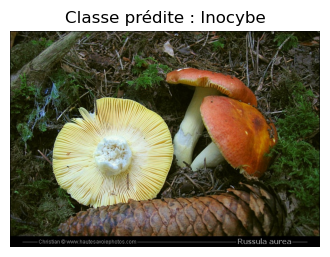

In [258]:
# Obtenir la classe réelle par rapport au chemin de l'image
image_label = df.loc[df['image_url'] == img_path]['label'].values[0]

plt.figure(figsize=(4, 4))
plt.imshow(img_web)
plt.title(f'Classe prédite : {nom_classe_predite}')
plt.axis('off')
plt.show()

# Rapports d'évaluation modèle

### Predictions sur le jeu de test

In [273]:
y_pred_test = model.predict(ds_test)
y_pred_test_classes = y_pred_test.argmax(axis=1)

119/119 [==============================] - 287s 2s/step


### Rapport de classification

In [274]:
report = classification_report(y_test, y_pred_test_classes, target_names=[nom_classes[i] for i in range(10)])
print(report)

              precision    recall  f1-score   support

  Agaricales       0.18      0.09      0.12      1383
    Agaricus       0.06      0.14      0.09       529
     Amanita       0.07      0.08      0.08       620
 Cortinarius       0.11      0.06      0.07       889
    Entoloma       0.07      0.13      0.09       493
     Inocybe       0.06      0.01      0.01       526
      Mycena       0.09      0.14      0.11       610
 Polyporales       0.13      0.13      0.13       889
 Psathyrella       0.09      0.11      0.10       655
     Russula       0.11      0.11      0.11       967

    accuracy                           0.10      7561
   macro avg       0.10      0.10      0.09      7561
weighted avg       0.11      0.10      0.10      7561



### Matrice de confusion

In [275]:
y_pred_classes_names = [nom_classes[i] for i in y_pred_test_classes]


# Créer un DataFrame pour les classes réelles et prédites
confusion_df = pd.DataFrame({'Classe': [nom_classes[i] for i in y_test], 'Prediction': y_pred_classes_names})

# Générer la matrice de confusion
matrice_confusion = pd.crosstab(confusion_df['Classe'], confusion_df['Prediction'], rownames=['Classe'], colnames=['Prediction'])

print(matrice_confusion)

Prediction   Agaricales  Agaricus  Amanita  Cortinarius  Entoloma  Inocybe  \
Classe                                                                       
Agaricales          122       215      115          104       165       12   
Agaricus             36        75       41           33        71        5   
Amanita              64        94       49           36        58        3   
Cortinarius          85       146       81           50       104        8   
Entoloma             37        85       49           38        62        6   
Inocybe              51        86       48           32        49        4   
Mycena               61       102       51           32        66        8   
Polyporales          68       137       73           55       115        8   
Psathyrella          67        82       57           40        75        7   
Russula              86       156      102           53       104        8   

Prediction   Mycena  Polyporales  Psathyrella  Russula  
Classe

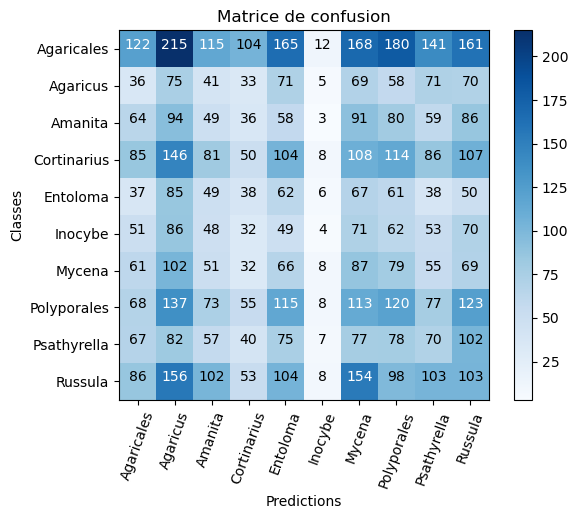

In [276]:
#import itertools  

matrice = confusion_matrix(y_test, y_pred_test_classes)
classes = [nom_classes[i] for i in range(10)]

plt.figure()

plt.imshow(matrice, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 70)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(matrice.shape[0]), range(matrice.shape[1])):
    plt.text(j, i, matrice[i, j],
             horizontalalignment = "center",
             color = "white" if matrice[i, j] > (matrice.max() / 2) else "black")

plt.ylabel('Classes')
plt.xlabel('Predictions')
plt.show()